##### Copyright 2020 The TensorFlow IO Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# 오디오 데이터 준비 및 증강

<table class="tfo-notebook-buttons" align="left">
  <td><a target="_blank" href="https://www.tensorflow.org/io/tutorials/audio"><img src="https://www.tensorflow.org/images/tf_logo_32px.png">TensorFlow.org에서 보기</a></td>
  <td><a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs-l10n/blob/master/site/ko/io/tutorials/audio.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png">Google Colab에서 실행하기</a></td>
  <td><a target="_blank" href="https://github.com/tensorflow/docs-l10n/blob/master/site/ko/io/tutorials/audio.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png">GitHub에서소스 보기</a></td>
      <td><a href="https://storage.googleapis.com/tensorflow_docs/docs-l10n/site/ko/io/tutorials/audio.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png">노트북 다운로드하기</a></td>
</table>

## 개요

자동 음성 인식의 가장 큰 문제 중 하나는 오디오 데이터를 준비하고 증강시키는 작업입니다. 오디오 데이터 분석에는 시간 또는 주파수 도메인이 포함될 수 있으므로 이미지와 같은 다른 데이터 소스와 비교하여 복잡도가 더욱 높습니다.

TensorFlow 에코시스템의 일부인 `tensorflow-io` 패키지는 오디오 데이터의 준비 및 증강을 간편하게 해주는 몇 가지 유용한 오디오 관련 API를 제공합니다.

## 설정

### 필수 패키지를 설치하고 런타임 다시 시작하기

In [2]:
!pip install -q tensorflow-io

## 사용법

### 오디오 파일 읽기

TensorFlow IO에서 `tfio.audio.AudioIOTensor` 클래스를 사용하면 오디오 파일을 지연 로드된 `IOTensor`로 읽을 수 있습니다.

In [3]:
import tensorflow as tf
import tensorflow_io as tfio

audio = tfio.audio.AudioIOTensor('gs://cloud-samples-tests/speech/brooklyn.flac')

print(audio)

<AudioIOTensor: shape=[28979     1], dtype=<dtype: 'int16'>, rate=16000>


위의 예에서 Flac 파일 `brooklyn.flac`는 [Google Cloud](https://cloud.google.com/speech-to-text/docs/quickstart-gcloud)에서 공개적으로 액세스할 수 있는 오디오 클립에서 가져온 것입니다.

GCS는 TensorFlow에서 지원되는 파일 시스템이므로 GCS 주소 `gs://cloud-samples-tests/speech/brooklyn.flac`가 직접 사용됩니다. `Flac` 형식 외에 `WAV`, `Ogg`, `MP3` 및 `MP4A`도 자동 파일 형식 감지 기능이 있는 `AudioIOTensor`에서 지원됩니다.

`AudioIOTensor`는 지연 로드되므로 처음에는 형상, dtype 및 샘플 속도만 표시됩니다. `AudioIOTensor`의 형상은 `[samples, channels]`로 표시됩니다. 이는 로드한 오디오 클립이 `int16`의 `28979`개 샘플을 갖는 모노 채널임을 의미합니다.

오디오 클립의 내용은 `to_tensor()`를 통해 또는 슬라이싱을 통해 `AudioIOTensor`를 `Tensor`로 변환하여 필요에 따라서만 판독됩니다. 슬라이싱은 큰 오디오 클립의 일부만 필요한 경우에 특히 유용합니다.

In [4]:
audio_slice = audio[100:]

# remove last dimension
audio_tensor = tf.squeeze(audio_slice, axis=[-1])

print(audio_tensor)

tf.Tensor([16 39 66 ... 56 81 83], shape=(28879,), dtype=int16)


오디오는 다음을 통해 재생할 수 있습니다.

In [5]:
from IPython.display import Audio

Audio(audio_tensor.numpy(), rate=audio.rate.numpy())

텐서를 부동 소수점 숫자로 변환하고 오디오 클립을 그래프로 표시하는 것이 더 편리합니다.

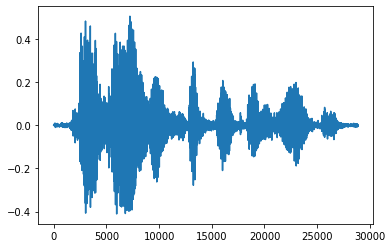

In [6]:
import matplotlib.pyplot as plt


tensor = tf.cast(audio_tensor, tf.float32) / 32768.0

plt.figure()
plt.plot(tensor.numpy())

### 노이즈 제거

때로는 오디오에서 노이즈를 제거하는 것이 합리적이며 이때 API `tfio.experimental.audio.trim`을 사용할 수 있습니다. API에서 세그먼트의 `[start, stop]` 위치 쌍이 반환됩니다.

tf.Tensor([ 2398 23546], shape=(2,), dtype=int64)
tf.Tensor(2398, shape=(), dtype=int64) tf.Tensor(23546, shape=(), dtype=int64)


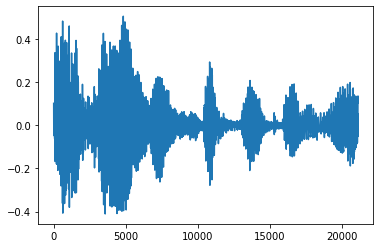

In [7]:
position = tfio.experimental.audio.trim(tensor, axis=0, epsilon=0.1)
print(position)

start = position[0]
stop = position[1]
print(start, stop)

processed = tensor[start:stop]

plt.figure()
plt.plot(processed.numpy())

### 페이드 인 및 페이드 아웃

유용한 오디오 엔지니어링 기술 중 하나는 오디오 신호를 점차적으로 늘리거나 줄이는 페이딩 기술입니다. 이 기술은 `tfio.experimental.audio.fade`를 통해 수행할 수 있습니다. `tfio.experimental.audio.fade`는 `linear` , `logarithmic` 또는 `exponential`과 같은 다양한 형상의 페이드를 지원합니다.

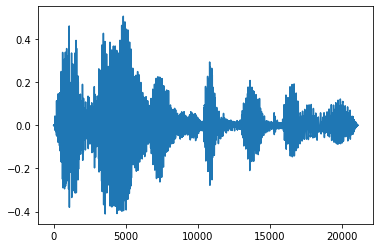

In [8]:
fade = tfio.experimental.audio.fade(
    processed, fade_in=1000, fade_out=2000, mode="logarithmic")

plt.figure()
plt.plot(fade.numpy())

### 스펙트럼 사진

고급 오디오 처리는 종종 시간 경과에 따른 주파수 변화에 적용됩니다. `tensorflow-io`에서 파형은 `tfio.experimental.audio.spectrogram`을 통해 스펙트럼 사진으로 변환할 수 있습니다.

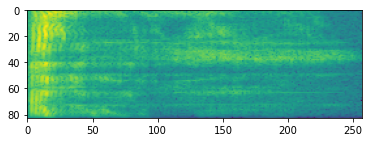

In [9]:
# Convert to spectrogram
spectrogram = tfio.experimental.audio.spectrogram(
    fade, nfft=512, window=512, stride=256)

plt.figure()
plt.imshow(tf.math.log(spectrogram).numpy())

다른 스케일로의 추가 변환도 가능합니다.

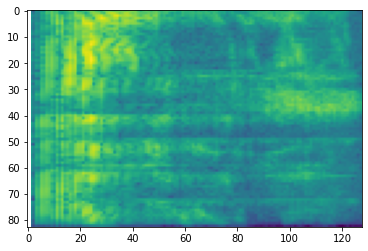

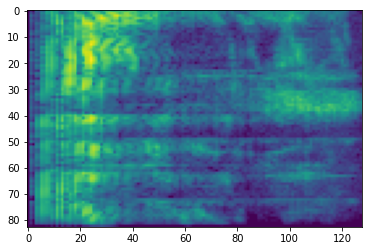

In [10]:
# Convert to mel-spectrogram
mel_spectrogram = tfio.experimental.audio.melscale(
    spectrogram, rate=16000, mels=128, fmin=0, fmax=8000)


plt.figure()
plt.imshow(tf.math.log(mel_spectrogram).numpy())

# Convert to db scale mel-spectrogram
dbscale_mel_spectrogram = tfio.experimental.audio.dbscale(
    mel_spectrogram, top_db=80)

plt.figure()
plt.imshow(dbscale_mel_spectrogram.numpy())

### SpecAugment

위에서 언급한 데이터 준비 및 증강 API 외에도 `tensorflow-io` 패키지는 고급 스펙트럼 사진 증강을 제공하며, 특히 [SpecAugment: 자동 음성 인식을 위한 간단한 데이터 증강 방법(Park 등, 2019)](https://arxiv.org/pdf/1904.08779.pdf)에서 논의된 주파수 및 시간 마스킹이 주목할만합니다.

#### 주파수 마스킹

주파수 마스킹에서 주파수 채널 `[f0, f0 + f)`이 마스킹됩니다. 여기서 `f`는 `0`부터 주파수 마스크 매개변수 `F`까지의 균일한 분포에서 선택되고 `f0`은 `(0, ν − f)`에서 선택됩니다. 여기서 `ν`는 주파수 채널의 수입니다.

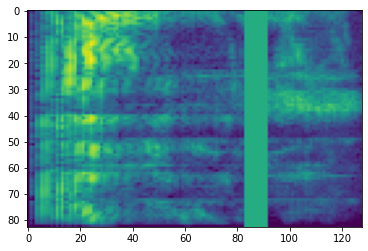

In [11]:
# Freq masking
freq_mask = tfio.experimental.audio.freq_mask(dbscale_mel_spectrogram, param=10)

plt.figure()
plt.imshow(freq_mask.numpy())

#### 시간 마스킹

시간 마스킹에서 `t` 연속 시간 스텝 `[t0, t0 + t)`이 마스킹됩니다. 여기서 `t`는 `0`부터 시간 마스킹 매개변수 `T`까지의 균일한 분포에서 선택되고 `t0`는 `[0, τ − t)`에서 선택됩니다. 여기서 `τ`는 시간 스텝입니다.

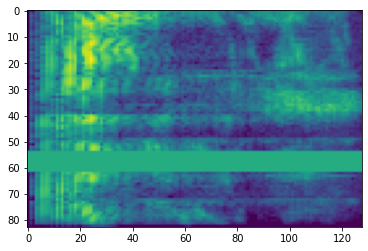

In [12]:
# Time masking
time_mask = tfio.experimental.audio.time_mask(dbscale_mel_spectrogram, param=10)

plt.figure()
plt.imshow(time_mask.numpy())